In [2]:
import pandas as pd
import numpy as np
import io
import os
import re
from google.colab import drive
!pip install tensorflow==1.15
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix

drive.mount('/content/drive')
print(tf.__version__)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1.15.0


In [3]:
path = '/content/drive/MyDrive/colab_data'
ratings = pd.read_csv(os.path.join(path, "ratings.csv"))

In [4]:
def change_id_from_0(data, column):
    data_copy = data.copy()
    for i in column:
        data_copy[i] = data_copy[i] - 1
    return data_copy

ratings = change_id_from_0(ratings, ['book_id','user_id'])
print('--------------ratings--------------')
display(ratings.head(3))


--------------ratings--------------


,book_id,user_id,rating
0,0,313,5
1,0,438,3
2,0,587,5


In [5]:
stats = ratings.describe()
stats

,book_id,user_id,rating
count,981756.000000,981756.000000,981756.000000
mean,4942.275636,25615.759933,3.856534
std,2873.207415,15228.338826,0.983941
min,0.000000,0.000000,1.000000
25%,2456.000000,12371.000000,3.000000
50%,4920.000000,25076.000000,4.000000
75%,7413.000000,38571.000000,5.000000
max,9999.000000,53423.000000,5.000000


## Split Training/Testing

In [6]:
def create_sparse_train_test(dataset, n_users, n_items, test_set_ratio = 0.1, seed=1):
    train_set, test_set = train_test_split(dataset, test_size = test_set_ratio, random_state = seed)
    test_set = test_set.values
    train_set = train_set.values
    
    i_tr, u_tr, r_tr = zip(*train_set)
    tr_sparse = coo_matrix((r_tr, (u_tr, i_tr)), shape = (n_users, n_items))
    
    i_ts, u_ts, r_ts = zip(*test_set)
    ts_sparse = coo_matrix((r_ts, (u_ts, i_ts)), shape = (n_users, n_items))
    
    return tr_sparse, ts_sparse

In [7]:
tr_sparse, ts_sparse = create_sparse_train_test(ratings, len(ratings.user_id.unique()), len(ratings.book_id.unique()))

In [8]:
print("sparse matrix dimension:",tr_sparse.shape,tr_sparse.row.shape,tr_sparse.col.shape,tr_sparse.data.min())
print("sparse matrix dimension:",ts_sparse.shape,ts_sparse.row.shape,ts_sparse.col.shape)
NITEMS = len(ratings.book_id.unique())
NUSERS = len(ratings.user_id.unique())
print('{} items, {} users, {} interactions'.format(NITEMS, NUSERS, len(ratings)))

sparse matrix dimension: (53424, 10000) (883580,) (883580,) 1
sparse matrix dimension: (53424, 10000) (98176,) (98176,)
10000 items, 53424 users, 981756 interactions


## Weighted Alternating Least Square Model

(10000,)


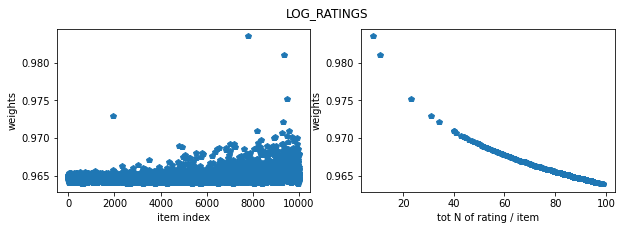

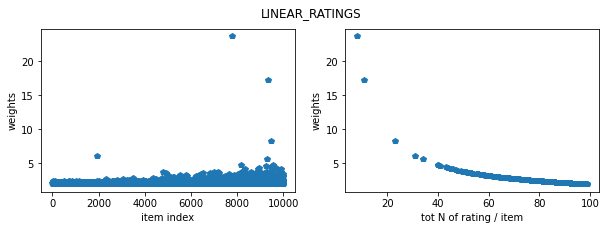

In [9]:
def make_weights(data, wt_type, obs_wt, feature_wt_exp, axis):
    """
    data: coo_matrix of ratings data
    wt_type: weight type, LOG_RATINGS or LINEAR_RATINGS
    obs_wt: linear weight factor
    feature_wt_exp: logarithmic weight factor
    axis: axis to make weights for, 1 = rows/users, 0 = cols/items
    """
    assert wt_type in ['LOG_RATINGS','LINEAR_RATINGS']
    frac = np.array(1.0 / (data > 0.0).sum(axis))
    frac[np.ma.masked_invalid(frac).mask] = 0
    
    if wt_type == 'LOG_RATINGS':
        wts = np.array(np.power(frac, feature_wt_exp)).flatten()
    elif wt_type == 'LINEAR_RATINGS':
        wts = np.array(obs_wt * frac).flatten()
    
    assert np.isfinite(wts).sum() == wts.shape[0]
    return wts

# Visualize Weight
import matplotlib.pyplot as plt
n_nonzero_items = np.array((tr_sparse > 0).sum(axis=0)).squeeze()
print(n_nonzero_items.shape)

def plot(col_wt,n_nonzero_items,title):
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    ax[0].plot(col_wt,"p")
    ax[0].set_xlabel("item index")
    ax[0].set_ylabel("weights")
    ax[1].plot(n_nonzero_items,col_wt,"p")
    ax[1].set_xlabel("tot N of rating / item")
    ax[1].set_ylabel("weights")
    plt.suptitle(title)
    plt.show()
    
for wt_type in ["LOG_RATINGS","LINEAR_RATINGS"]:    
    col_wt = make_weights(tr_sparse, wt_type, obs_wt=189.8, feature_wt_exp=0.008, axis=0)
    plot(col_wt,n_nonzero_items,title=wt_type)


In [10]:
from tensorflow.contrib.factorization.python.ops import factorization_ops
def define_graph(data,PARAMS):
    graph = tf.Graph()
    with graph.as_default():

        input_tensor = tf.SparseTensor(indices=np.array([data.row, data.col]).T,
                                       values=(data.data).astype(np.float32),
                                       dense_shape=data.shape)


        row_wts = None
        col_wts = None
        num_rows = data.shape[0]
        num_cols = data.shape[1]

        # initialize the weights 
        if PARAMS["wt_type"] in ["LOG_RATINGS","LINEAR_RATINGS"]:
            row_wts = np.ones(num_rows)
            col_wts = make_weights(data, 
                               PARAMS["wt_type"], 
                               PARAMS['feature_wt_factor'],
                               PARAMS['feature_wt_exp'],axis=0)

        model = factorization_ops.WALSModel(num_rows, num_cols, PARAMS["latent_factors"],
                                            unobserved_weight=PARAMS["unobs_weight"],
                                            regularization=PARAMS["regularization"],
                                            row_weights=row_wts,
                                            col_weights=col_wts)

        return(graph,model,input_tensor)

In [11]:
def train(graph,model,input_tensor,verbose=False):
    sess = tf.Session(graph=graph)
    with graph.as_default():
        row_update_op = model.update_row_factors(sp_input=input_tensor)[1]
        col_update_op = model.update_col_factors(sp_input=input_tensor)[1]

        sess.run(model.initialize_op)
        sess.run(model.worker_init)
        for i in range(num_iterations):
            sess.run(model.row_update_prep_gramian_op)
            sess.run(model.initialize_row_update_op)
            sess.run(row_update_op)
            sess.run(model.col_update_prep_gramian_op)
            sess.run(model.initialize_col_update_op)
            sess.run(col_update_op)
            if verbose and i % 1 == 0:
                rf = sess.run(row_factor)
                print("iter",i,rf.mean(),rf.min(),sess.run(col_factor).mean())
    return sess 

import math
def get_rmse(output_row, output_col, actual):
        """Compute rmse between predicted and actual ratings.
        Args:
          output_row: evaluated numpy array of row_factor
          output_col: evaluated numpy array of col_factor
          actual: coo_matrix of actual (test) values
        Returns:
          rmse
        """
        mse = 0
        rate_preds = []
        for i in range(actual.data.shape[0]):
            row_pred = output_row[actual.row[i]]
            col_pred = output_col[actual.col[i]]
            rate_pred = np.dot(row_pred, col_pred)
            rate_preds.append(rate_pred)
            err = actual.data[i] - rate_pred
            mse += err * err
        mse /= actual.data.shape[0]
        rmse = math.sqrt(mse)
        return rmse,rate_preds

In [12]:
PARAMS = {
    'regularization': 0.01,
    'unobs_weight': .001,  
    'feature_wt_factor': 189.8,
    'feature_wt_exp': 0.08,
}

In [13]:
latent_factors  = [1,  2,   5, 15]
regularizations = [0.001,0.1,  5, 20,100]
wt_types = ["UNIFORM","LINEAR_RATINGS","LOG_RATINGS"]
rmse_best = np.Inf
num_iterations = 40
for wt_type in wt_types:
    print(wt_type)
    for lf in latent_factors:
        for r in regularizations:
            PARAMS["wt_type"] = wt_type
            PARAMS["latent_factors"] = lf
            PARAMS["regularizations"] = r

            graph,model,input_tensor = define_graph(tr_sparse,PARAMS)
            sess = train(graph,model,input_tensor)

            output_row = model.row_factors[0].eval(session=sess)
            output_col = model.col_factors[0].eval(session=sess)        

            rmse_train, _ = get_rmse(output_row, output_col, tr_sparse)
            rmse_test, rate_preds_test = get_rmse(output_row, output_col, ts_sparse)
            print("{:10} latent factor {:3.0f}, reg {:5.1f}, rmse (train) {:5.2f}, rmse (test) {:5.2f}".format(" ",
                                                                                                               lf,
                                                                                                               r,
                                                                                                               rmse_train,
                                                                                                               rmse_test))
            if rmse_test < rmse_best:
                rmse_best = rmse_test
                out = {
                      "rate_preds_test":rate_preds_test,
                      "rmse":rmse_test,
                      "output_row":output_row,
                      "output_col":output_col,
                      "params": PARAMS
                      }

UNIFORM
           latent factor   1, reg   0.0, rmse (train)  3.95, rmse (test)  3.95
           latent factor   1, reg   0.1, rmse (train)  3.95, rmse (test)  3.95
           latent factor   1, reg   5.0, rmse (train)  3.95, rmse (test)  3.95
           latent factor   1, reg  20.0, rmse (train)  3.95, rmse (test)  3.95
           latent factor   1, reg 100.0, rmse (train)  3.95, rmse (test)  3.95
           latent factor   2, reg   0.0, rmse (train)  3.93, rmse (test)  3.93
           latent factor   2, reg   0.1, rmse (train)  3.93, rmse (test)  3.93
           latent factor   2, reg   5.0, rmse (train)  3.93, rmse (test)  3.93
           latent factor   2, reg  20.0, rmse (train)  3.93, rmse (test)  3.93
           latent factor   2, reg 100.0, rmse (train)  3.93, rmse (test)  3.93
           latent factor   5, reg   0.0, rmse (train)  3.90, rmse (test)  3.90
           latent factor   5, reg   0.1, rmse (train)  3.90, rmse (test)  3.90
           latent factor   5, reg   5.0, rms

In [17]:
output_row.shape

(53424, 15)

In [18]:
output_col.shape

(10000, 15)

In [35]:
i = 0
print(tr_sparse.row[i])
print(output_row[tr_sparse.row[i]])
print(output_row[30117])

30117
[-0.72755504  0.2721139  -0.33889163 -0.322146   -0.48045266  0.10904129
  0.53850204  0.11212166 -0.05398895 -0.16874848  0.32790282  0.1300478
  0.60678226 -1.4431714  -0.30790293]
[-0.72755504  0.2721139  -0.33889163 -0.322146   -0.48045266  0.10904129
  0.53850204  0.11212166 -0.05398895 -0.16874848  0.32790282  0.1300478
  0.60678226 -1.4431714  -0.30790293]


In [34]:
i = 1
print(tr_sparse.col[i])
print(output_col[tr_sparse.col[i]])

4403
[-0.8307707  -0.4819777   1.0630914   0.48243517  0.11226083  0.9110728
 -1.7230009   1.9636053   0.6852343  -1.698267    0.20536159  0.2826137
 -0.33110753 -0.38804087 -1.1149062 ]


In [37]:
user_latent = pd.DataFrame(output_row)
print(user_latent.head(3))
item_latent = pd.DataFrame(output_col)
print(item_latent.head(3))

print(user_latent.shape)
print(item_latent.shape)

         0         1         2   ...        12        13        14
0  0.199595 -0.108096  0.247037  ...  0.041728  0.185200 -0.358743
1 -0.212097 -0.068822  0.102718  ... -0.156847  0.019408 -0.642446
2 -0.057435 -0.006853  0.118266  ... -0.047005  0.054901 -0.032876

[3 rows x 15 columns]
         0         1         2   ...        12        13        14
0  1.900808  0.380494  0.661577  ... -0.702245 -0.751551 -0.541900
1  1.694283  0.602090  0.477443  ... -0.551353 -0.573139 -0.660848
2  1.265569  0.245617  0.385378  ... -0.768754 -0.879207 -0.654471

[3 rows x 15 columns]
(53424, 15)
(10000, 15)


In [38]:
user_latent.to_csv(os.path.join(path, "user_latent.csv"), index=True)
item_latent.to_csv(os.path.join(path, "item_latent.csv"), index=True)